# Nivell 1
- Exercici 1
Parteix el conjunt de dadesDelayedFlights.csv en train i test. Estudia els dos conjunts per separat, a nivell descriptiu.



In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
#from sklearn.preprocessing import StandardScaler


In [163]:
flightsdf=pd.read_csv('DelayedFlights.csv', index_col=0) #a vegades cal posar index_col=0 si no fos detectat inicialment
flightsdf.info()

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1936758 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [164]:
flightsdf.shape[0:2]

(1936758, 29)

In [165]:
## SIMPLIFICAR MEGABLOC de dades
#sumant delays es genera una nov columna agregant tots els retards a cada vol
#per DEFINICIO: Actual Elapsed Time=Taxi In+Taxi Out+Airtime operations ; 
#per DEFINICIO ArrivalDelay= carrierdelay+weatherdelay+NASdelay+LateAircraftdelay
flightsdf['delaytime']=flightsdf['CarrierDelay']+flightsdf['WeatherDelay']+flightsdf['NASDelay']+flightsdf['SecurityDelay']+flightsdf['LateAircraftDelay']+flightsdf['DepDelay']+flightsdf['TaxiIn']+flightsdf['TaxiOut']
#elimino els que NO han volat (airtime=0)
flightsdf.drop(flightsdf[flightsdf.AirTime==0].index, inplace=True) #, axis=0, inplace=True)
flightsdf['avgspeed']=60*flightsdf['Distance']/flightsdf['AirTime'] #en km/h
flightsdf['DepDate'] = pd.to_datetime(flightsdf.Year*10000+flightsdf.Month*100+flightsdf.DayofMonth,format='%Y%m%d')
compactdf=pd.DataFrame(flightsdf, columns=['DepDate','DayOfWeek','CRSDepTime','UniqueCarrier','FlightNum','DepDelay','ActualElapsedTime','Origin','Dest','Distance','avgspeed','delaytime','ArrDelay'])
compactdf.dropna(inplace=True) #puc eliminar els NaN en general o podria eliminar només els que no tenen retards
compactdf[100:110]

,DepDate,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ActualElapsedTime,Origin,Dest,Distance,avgspeed,delaytime,ArrDelay
223,2008-01-03,4,2040,WN,1682,60.0,54.0,LAS,PHX,256,384.000000,128.0,54.0
225,2008-01-03,4,1450,WN,2726,31.0,64.0,LAS,PHX,256,333.913043,79.0,30.0
226,2008-01-03,4,1945,WN,2991,75.0,55.0,LAS,PHX,256,357.209302,152.0,65.0
227,2008-01-03,4,1630,WN,3517,27.0,68.0,LAS,PHX,256,313.469388,66.0,20.0
230,2008-01-03,4,1745,WN,512,40.0,229.0,LAS,PIT,1910,545.714286,83.0,24.0
232,2008-01-03,4,1600,WN,416,30.0,293.0,LAS,PVD,2363,533.007519,90.0,33.0
234,2008-01-03,4,1725,WN,1509,59.0,237.0,LAS,RDU,2027,547.837838,110.0,36.0
235,2008-01-03,4,1630,WN,239,46.0,74.0,LAS,RNO,345,345.000000,95.0,35.0
236,2008-01-03,4,1855,WN,298,33.0,66.0,LAS,RNO,345,383.333333,64.0,19.0
238,2008-01-03,4,1730,WN,675,11.0,84.0,LAS,RNO,345,363.157895,53.0,15.0


#### preprocessem en variables NUMERIQUES i ORDINALS després de veure com son estadisticament

In [166]:
### SPLIT en 2 jocs i verificacio estadistica dels dos
X=compactdf[['DepDate','DayOfWeek','CRSDepTime','UniqueCarrier','FlightNum','DepDelay','ActualElapsedTime','Origin','Dest','Distance','avgspeed','ArrDelay']]
y=compactdf['delaytime']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

In [167]:
X_train.describe()

,DayOfWeek,CRSDepTime,FlightNum,DepDelay,ActualElapsedTime,Distance,avgspeed,ArrDelay
count,997986.000000,997986.000000,997986.000000,997986.000000,997986.000000,997986.000000,997986.000000,997986.000000
mean,3.980378,1487.733142,2276.194466,59.657346,135.424786,741.823364,388.237136,63.282659
std,1.993251,421.197410,1996.612350,59.917751,72.356423,559.543027,108.591069,60.805416
min,1.000000,0.000000,1.000000,6.000000,15.000000,11.000000,21.290323,15.000000
25%,2.000000,1150.000000,637.000000,24.000000,83.000000,334.000000,342.631579,26.000000
50%,4.000000,1528.000000,1590.000000,41.000000,118.000000,595.000000,395.294118,43.000000
75%,6.000000,1830.000000,3676.750000,75.000000,167.000000,972.000000,440.207254,79.000000
max,7.000000,2359.000000,9741.000000,2467.000000,1114.000000,4962.000000,55920.000000,2461.000000


In [168]:
X_test.describe()

,DayOfWeek,CRSDepTime,FlightNum,DepDelay,ActualElapsedTime,Distance,avgspeed,ArrDelay
count,249497.000000,249497.000000,249497.000000,249497.000000,249497.000000,249497.000000,249497.000000,249497.000000
mean,3.978906,1488.813549,2277.837597,59.756727,135.190339,740.640008,387.879511,63.324565
std,1.993335,421.102992,2001.277501,59.674006,72.055774,558.650499,78.999649,60.548385
min,1.000000,1.000000,1.000000,6.000000,14.000000,30.000000,41.092437,15.000000
25%,2.000000,1151.000000,638.000000,24.000000,82.000000,334.000000,342.380952,26.000000
50%,4.000000,1529.000000,1587.000000,41.000000,118.000000,595.000000,395.121951,43.000000
75%,6.000000,1830.000000,3676.000000,75.000000,167.000000,967.000000,440.204082,79.000000
max,7.000000,2359.000000,7829.000000,1597.000000,693.000000,4962.000000,6690.000000,1655.000000


In [169]:
y_train.describe()

count    997986.000000
mean        150.914027
std         122.560823
min          30.000000
25%          75.000000
50%         111.000000
75%         183.000000
max        4942.000000
Name: delaytime, dtype: float64

In [170]:
y_test.describe()

count    249497.000000
mean        150.971082
std         122.042803
min          31.000000
25%          75.000000
50%         111.000000
75%         183.000000
max        3319.000000
Name: delaytime, dtype: float64

In [171]:
#compararem restant i normalitzant contra el test EN PERCENTATGE.
(X_train.describe()-X_test.describe())*100/X_test.describe()

,DayOfWeek,CRSDepTime,FlightNum,DepDelay,ActualElapsedTime,Distance,avgspeed,ArrDelay
count,299.999198,299.999198,299.999198,299.999198,299.999198,299.999198,299.999198,299.999198
mean,0.037018,-0.072568,-0.072136,-0.166309,0.173420,0.159775,0.092200,-0.066176
std,-0.004213,0.022422,-0.233109,0.408462,0.417244,0.159765,37.457660,0.424505
min,0.000000,-100.000000,0.000000,0.000000,7.142857,-63.333333,-48.189195,0.000000
25%,0.000000,-0.086881,-0.156740,0.000000,1.219512,0.000000,0.073201,0.000000
50%,0.000000,-0.065402,0.189036,0.000000,0.000000,0.000000,0.043573,0.000000
75%,0.000000,0.000000,0.020403,0.000000,0.000000,0.517063,0.000721,0.000000
max,0.000000,0.000000,24.422021,54.477145,60.750361,0.000000,735.874439,48.700906


In [172]:
(y_train.describe()-y_test.describe())*100/y_test.describe()

count    299.999198
mean      -0.037792
std        0.424458
min       -3.225806
25%        0.000000
50%        0.000000
75%        0.000000
max       48.900271
Name: delaytime, dtype: float64

Veiem que quasi son idèntics els dos blocs. De fet, jugant amb diverses fraccions es pot apretar fins a un split de 0,9 i surten prou semblants (mentre que es recomana splits de 0,2 ... 0,5)

# Nivell 2
- Exercici 2
Aplica algun procés de transformació (estandarditzar les dades numèriques, crear columnes dummies, polinomis...).



In [173]:
#codificar origens ....-> onehotencoder de N nivells (no ho faig pq pesa i no és visual, fa matriu sparse)
#posar en bins les hores de sortida .... transformer OK
#normalitzar els retards per ElapsedTime
#posar en bins els retards
#eliminar outliers de avgspeed

In [174]:
bins = [0, 400, 800, 1200, 1600, 2000, np.inf]
labels = [1, 2, 3, 4, 5, 6] #'infant', 'kid', 'teen', 'adult', 'senior citizen'
transformer = preprocessing.FunctionTransformer(
    pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False}
)
X=compactdf['CRSDepTime'] #X = np.array([0.2, 2, 15, 25, 97])
compactdf['CRSDepTimet']=transformer.fit_transform(X)
compactdf['CRSDepTimet'].head()

4     5
6     5
11    4
16    4
18    4
Name: CRSDepTimet, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [175]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

compactdf['Ndelaytime'] = compactdf['ActualElapsedTime']/compactdf['delaytime']
compactdf['Ndelaytime'].head()

4     1.111111
6     1.791045
11    0.643617
16    4.000000
18    2.157895
Name: Ndelaytime, dtype: float64

In [177]:
#i ara els escalo entre 0 i 1

scaler=MinMaxScaler()  #StandardScaler() ->aquest em deixaria valors també negatius!
reduit=scaler.fit_transform(compactdf[['Ndelaytime','ActualElapsedTime']])
reduit
compactdf.head()

,DepDate,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ActualElapsedTime,Origin,Dest,Distance,avgspeed,delaytime,ArrDelay,CRSDepTimet,Ndelaytime
4,2008-01-03,4,1755,WN,3920,34.0,90.0,IND,BWI,515,401.298701,81.0,34.0,5,1.111111
6,2008-01-03,4,1830,WN,509,67.0,240.0,IND,LAS,1591,415.043478,134.0,57.0,5,1.791045
11,2008-01-03,4,1510,WN,1333,94.0,121.0,IND,MCO,828,464.299065,188.0,80.0,4,0.643617
16,2008-01-03,4,1425,WN,675,27.0,228.0,IND,PHX,1489,419.436620,57.0,15.0,4,4.000000
18,2008-01-03,4,1255,WN,4,28.0,123.0,IND,TPA,838,457.090909,57.0,16.0,4,2.157895


# Nivell 3
- Exercici 3
Resumeix les noves columnes generades de manera estadística i gràfica

In [178]:
newcols=pd.DataFrame(reduit, columns=['Nndelaytime','ActualElapsedTime'])
compactdf['Ndelaytime']=newcols.Nndelaytime
compactdf['Nactualelapsedtime']=newcols.ActualElapsedTime
compactdf.head()

,DepDate,DayOfWeek,CRSDepTime,UniqueCarrier,FlightNum,DepDelay,ActualElapsedTime,Origin,Dest,Distance,avgspeed,delaytime,ArrDelay,CRSDepTimet,Ndelaytime,Nactualelapsedtime
4,2008-01-03,4,1755,WN,3920,34.0,90.0,IND,BWI,515,401.298701,81.0,34.0,5,0.133875,0.099091
6,2008-01-03,4,1830,WN,509,67.0,240.0,IND,LAS,1591,415.043478,134.0,57.0,5,0.057320,0.039091
11,2008-01-03,4,1510,WN,1333,94.0,121.0,IND,MCO,828,464.299065,188.0,80.0,4,0.165709,0.110909
16,2008-01-03,4,1425,WN,675,27.0,228.0,IND,PHX,1489,419.436620,57.0,15.0,4,0.081122,0.051818
18,2008-01-03,4,1255,WN,4,28.0,123.0,IND,TPA,838,457.090909,57.0,16.0,4,0.075725,0.065455


In [180]:
compactdf['Ndelaytime'].describe()

count    266081.000000
mean          0.078239
std           0.060431
min           0.000190
25%           0.036739
50%           0.062449
75%           0.100942
max           0.761090
Name: Ndelaytime, dtype: float64

In [179]:
compactdf['Nactualelapsedtime'].describe(

count    266081.000000
mean          0.110274
std           0.066007
min           0.002727
25%           0.061818
50%           0.094545
75%           0.139091
max           0.621818
Name: Nactualelapsedtime, dtype: float64

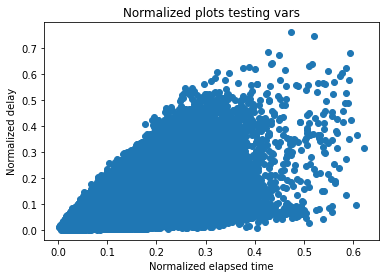

In [182]:
from matplotlib import pyplot as plt
plt.scatter(compactdf['Nactualelapsedtime'], compactdf['Ndelaytime'])
plt.title('Normalized plots testing vars')
plt.xlabel('Normalized elapsed time')
plt.ylabel('Normalized delay')
plt.show()

# NO FA PINTA DE SER UN DIBUIX GAIRE ACLARIDOR. 
### obviament hi ha una fortissima autocorrelació entre variables
### cal seguir explorant altres combinacions
